# eWaterCycle containerized model

This notebook is to showcase/test the containerized model.

We import the LeakyBucket model:

In [1]:
from ewatercycle_leakybucket.model import LeakyBucket

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
/home/bart/micromamba/envs/ewatercycle/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


To be able to initialize the model, we need forcing data:

In [2]:
from ewatercycle.base.forcing import GenericLumpedForcing
import ewatercycle
from pathlib import Path
import numpy as np

shape = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"

cmip_dataset = {
    "dataset": "EC-Earth3",
    "project": "CMIP6",
    "grid": "gr",
    "exp": ["historical",],
    "ensemble": "r6i1p1f1",
}

forcing = GenericLumpedForcing.generate(
    dataset=cmip_dataset,
    start_time="2000-01-01T00:00:00Z",
    end_time="2000-12-31T00:00:00Z",
    shape=shape.absolute(),
)

Now we can start the model. The `LeakyBucket` class uses a container hosted on the Github container registry.

Alternatively, you can start the model using a local container. For this you would modify the command as such:

```py
from ewatercycle.container import ContainerImage
LeakyBucket(forcing=forcing, bmi_image=ContainerImage("local_image:latest"))
```

In [3]:
model = LeakyBucket(forcing=forcing) 
cfg_file, _ = model.setup(leakiness=0.10)

In [4]:
model.initialize(cfg_file)

In [5]:
model.bmi.get_component_name()

'leakybucket'

To test the model, we'll make a hydrograph:

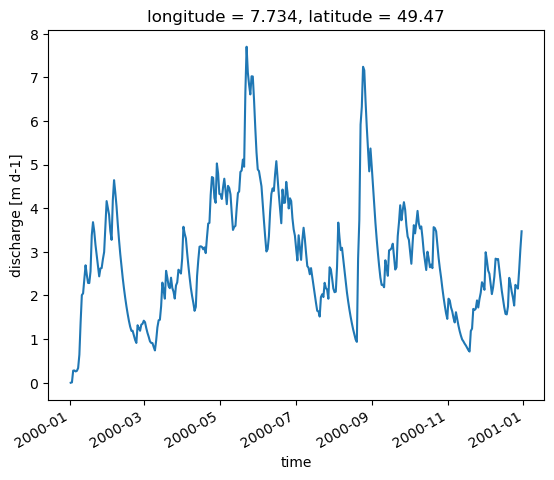

In [6]:
import xarray as xr

discharges = []
while model.time < model.end_time:
    discharges.append(model.get_value_as_xarray("discharge"))
    model.update()

discharge = xr.concat(discharges, dim="time")
discharge.plot()